In [2]:
# Cell 1: mount drive and extract specific folder from the zip
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
# Cell 2 (Fixed): Extract only "IDC_regular_ps50_idx5/" folder from idc.zip
ZIP_PATH = "/content/drive/MyDrive/idc.zip"   # <- change path if different
DEST = "/content/IDC_data"

# Create destination folder
!mkdir -p "$DEST"

# Extract only the IDC_regular_ps50_idx5 folder from the zip
!unzip -q "$ZIP_PATH" "IDC_regular_ps50_idx5/*" -d "$DEST"

# Verify a few files
!ls -lah "$DEST/IDC_regular_ps50_idx5" | head -n 10


total 1.2M
drwxr-xr-x 281 root root  12K Oct 23 17:34 .
drwxr-xr-x   3 root root 4.0K Oct 23 17:33 ..
drwxr-xr-x   4 root root 4.0K Oct 23 17:33 10253
drwxr-xr-x   4 root root 4.0K Oct 23 17:33 10254
drwxr-xr-x   4 root root 4.0K Oct 23 17:33 10255
drwxr-xr-x   4 root root 4.0K Oct 23 17:33 10256
drwxr-xr-x   4 root root 4.0K Oct 23 17:33 10257
drwxr-xr-x   4 root root 4.0K Oct 23 17:33 10258
drwxr-xr-x   4 root root 4.0K Oct 23 17:33 10259


In [2]:
# Cell 3: Organize IDC patches into class0 and class1 folders (recursive + safe)
import re, shutil
from pathlib import Path

SRC_ROOT = Path("/content/IDC_data")  # after unzip
TARGET_ROOT = Path("/content/idc_dataset")
CLASS0_DIR = TARGET_ROOT / "class0"
CLASS1_DIR = TARGET_ROOT / "class1"

CLASS0_DIR.mkdir(parents=True, exist_ok=True)
CLASS1_DIR.mkdir(parents=True, exist_ok=True)

pattern = re.compile(r".*_class([01])\.png$", re.IGNORECASE)

found0 = found1 = skipped = 0
for p in SRC_ROOT.rglob("*.png"):
    m = pattern.match(p.name)
    if not m:
        skipped += 1
        continue
    cls = m.group(1)
    if cls == "0":
        shutil.copy(p, CLASS0_DIR / p.name)
        found0 += 1
    else:
        shutil.copy(p, CLASS1_DIR / p.name)
        found1 += 1

print(f"✅ Copied -> class0: {found0}, class1: {found1}, skipped: {skipped}")
print("Sample class0 files:", [p.name for p in list(CLASS0_DIR.iterdir())[:5]])
print("Sample class1 files:", [p.name for p in list(CLASS1_DIR.iterdir())[:5]])


✅ Copied -> class0: 198738, class1: 78786, skipped: 0
Sample class0 files: ['9250_idx5_x1451_y151_class0.png', '12749_idx5_x1851_y351_class0.png', '14188_idx5_x1401_y1201_class0.png', '9126_idx5_x601_y1001_class0.png', '12752_idx5_x501_y1651_class0.png']
Sample class1 files: ['13462_idx5_x501_y1001_class1.png', '12626_idx5_x1451_y701_class1.png', '10303_idx5_x1301_y1501_class1.png', '13402_idx5_x2001_y301_class1.png', '8959_idx5_x1201_y2301_class1.png']


In [3]:
# Cell 4: Split dataset into train/val/test maintaining class balance
import random, shutil
from pathlib import Path

random.seed(42)

SRC = Path("/content/idc_dataset")
OUT = Path("/content/idc_split")
for split in ["train", "val", "test"]:
    for cls in ["class0", "class1"]:
        (OUT / split / cls).mkdir(parents=True, exist_ok=True)

ratios = (0.8, 0.1, 0.1)
for cls in ["class0", "class1"]:
    files = list((SRC / cls).glob("*.png"))
    random.shuffle(files)
    n = len(files)
    n_train, n_val = int(n * ratios[0]), int(n * ratios[1])
    train, val, test = files[:n_train], files[n_train:n_train + n_val], files[n_train + n_val:]
    for f in train: shutil.copy(f, OUT / "train" / cls / f.name)
    for f in val:   shutil.copy(f, OUT / "val" / cls / f.name)
    for f in test:  shutil.copy(f, OUT / "test" / cls / f.name)

for split in ["train", "val", "test"]:
    c0 = len(list((OUT / split / "class0").glob("*.png")))
    c1 = len(list((OUT / split / "class1").glob("*.png")))
    print(f"{split}: class0={c0}, class1={c1}, total={c0 + c1}")


train: class0=158990, class1=63028, total=222018
val: class0=19873, class1=7878, total=27751
test: class0=19875, class1=7880, total=27755


In [4]:

# Cell 5: Verify dataset counts and show random sample file names
from pathlib import Path
import random

root = Path("/content/idc_split")
class_totals = {"class0": 0, "class1": 0}
for split in ["train", "val", "test"]:
    for cls in ["class0", "class1"]:
        count = len(list((root / split / cls).glob("*.png")))
        class_totals[cls] += count
        print(f"{split}/{cls}: {count}")
print("\nOverall totals:", class_totals)

# show a few random filenames
sample0 = random.sample(list((root/"train"/"class0").glob("*.png")), 5)
sample1 = random.sample(list((root/"train"/"class1").glob("*.png")), 5)
print("\nExample class0 files:", [p.name for p in sample0])
print("Example class1 files:", [p.name for p in sample1])


train/class0: 158990
train/class1: 63028
val/class0: 19873
val/class1: 7878
test/class0: 19875
test/class1: 7880

Overall totals: {'class0': 198738, 'class1': 78786}

Example class0 files: ['13693_idx5_x101_y1051_class0.png', '10264_idx5_x1751_y501_class0.png', '9257_idx5_x451_y1851_class0.png', '9125_idx5_x1101_y2001_class0.png', '12909_idx5_x251_y1451_class0.png']
Example class1 files: ['9077_idx5_x1551_y551_class1.png', '10253_idx5_x851_y401_class1.png', '10308_idx5_x2151_y1701_class1.png', '10302_idx5_x1801_y551_class1.png', '12822_idx5_x1251_y701_class1.png']


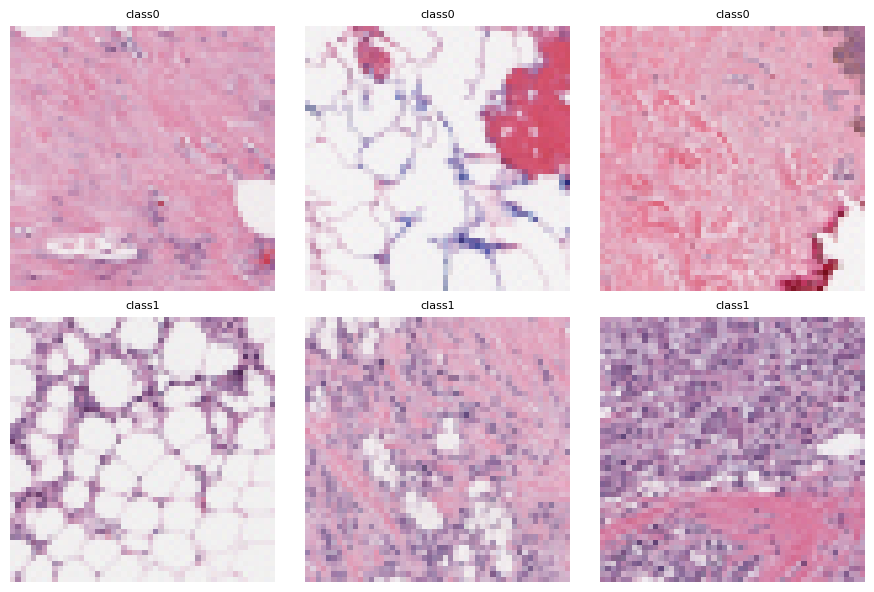

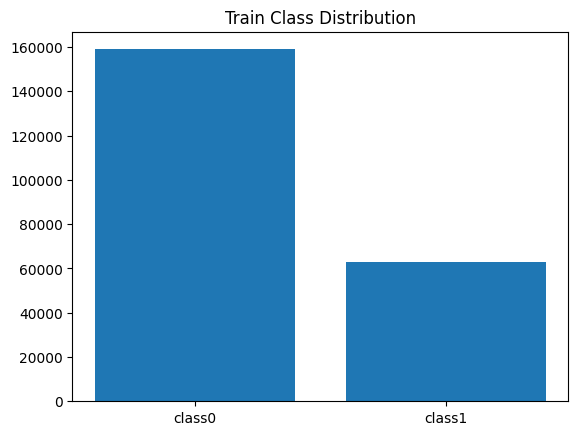

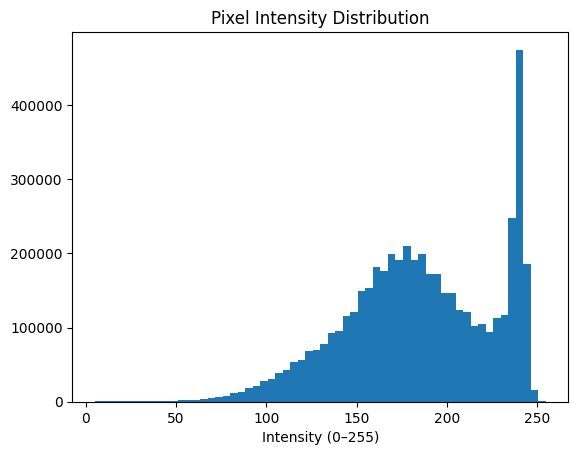

Intensity stats — min: 5.0 max: 254.66667 mean: 185.08722 std: 41.153015


In [5]:
# Cell 6: EDA - sample visuals and pixel statistics
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from pathlib import Path

test_c0 = list(Path("/content/idc_split/test/class0").glob("*.png"))
test_c1 = list(Path("/content/idc_split/test/class1").glob("*.png"))

# Display 3 samples per class
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i in range(3):
    axes[0, i].imshow(Image.open(test_c0[i]))
    axes[0, i].set_title("class0", fontsize=8)
    axes[0, i].axis("off")
    axes[1, i].imshow(Image.open(test_c1[i]))
    axes[1, i].set_title("class1", fontsize=8)
    axes[1, i].axis("off")
plt.tight_layout()
plt.show()

# Class distribution (train)
train_c0 = len(list(Path("/content/idc_split/train/class0").glob("*.png")))
train_c1 = len(list(Path("/content/idc_split/train/class1").glob("*.png")))
plt.bar(["class0", "class1"], [train_c0, train_c1])
plt.title("Train Class Distribution")
plt.show()

# Pixel intensity histogram (sample 2000 images)
train_files = list(Path("/content/idc_split/train/class0").glob("*.png")) + \
               list(Path("/content/idc_split/train/class1").glob("*.png"))
sample = random.sample(train_files, min(2000, len(train_files)))

intensities = []
for p in sample:
    img = np.array(Image.open(p)).astype(np.float32)
    intensities.append(img.mean(axis=2).ravel())
intensities = np.concatenate(intensities)

plt.hist(intensities, bins=60)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Intensity (0–255)")
plt.show()
print("Intensity stats — min:", intensities.min(),
      "max:", intensities.max(),
      "mean:", intensities.mean(),
      "std:", intensities.std())


In [6]:
# Rebuild train_ds, val_ds, and test_ds if they are not in memory
import tensorflow as tf

DATA_DIR = "/content/idc_split"
IMG_SIZE = (50, 50)
BATCH_SIZE = 128

# Create datasets from directory structure
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/train",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/val",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/test",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Enable prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

# Quick sanity check
for images, labels in train_ds.take(1):
    print("✅ Dataset loaded successfully")
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break


Found 222018 files belonging to 2 classes.
Found 27751 files belonging to 2 classes.
Found 27755 files belonging to 2 classes.
✅ Dataset loaded successfully
Image batch shape: (128, 50, 50, 3)
Label batch shape: (128, 1)


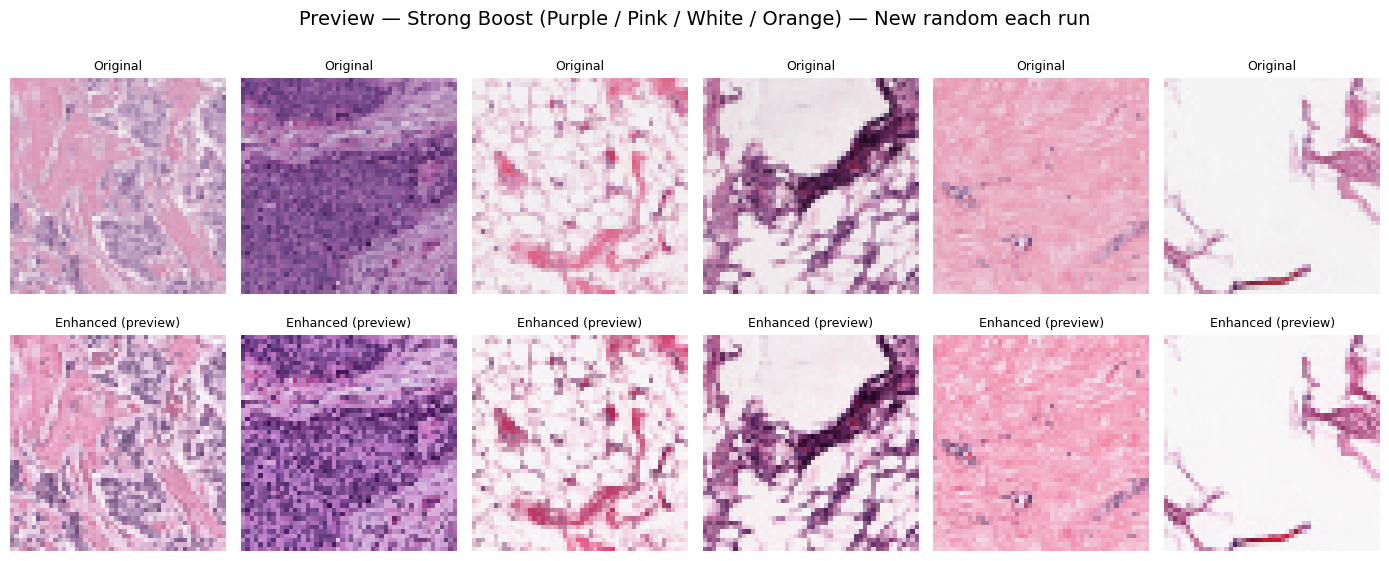

In [28]:
# ✅ Preview-only: Slightly stronger enhancement (new random images each run)
import cv2, numpy as np, random, matplotlib.pyplot as plt
from glob import glob
from pathlib import Path

# ---------- Tuned constants (stronger but still natural) ----------
CLAHE_CLIP = 1.0
CLAHE_GRID = (6,6)
GLOBAL_SAT = 1.03
GLOBAL_VAL = 1.04

# Regional boosts
RED_SAT_BOOST = 1.12      # orange/red
RED_VAL_BOOST = 1.09
PINK_SAT_BOOST = 1.12     # pink tones
PINK_VAL_BOOST = 1.08
PURPLE_SAT_BOOST = 1.10   # purple tint
PURPLE_VAL_BOOST = 1.07

WHITE_THRESHOLD = 180
WHITE_BOOST = 1.12        # stronger white lift

UNSHARP_AMOUNT = 0.12     # clearer detail
BLEND_ALPHA = 0.40        # blend sharper result more in

# ---------- Safe fallback helper (identity) ----------
def preprocess_pro_final_v2(img_uint8):
    return img_uint8

# ---------- Enhanced preprocess function ----------
def preprocess_idc_balanced_colorboost_preview_stronger(img_uint8):
    """
    Input: RGB uint8
    Output: RGB uint8 (enhanced)
    """
    base = preprocess_pro_final_v2(img_uint8)

    # CLAHE on L (Lab)
    lab = cv2.cvtColor(base, cv2.COLOR_RGB2LAB)
    L, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_GRID)
    L2 = clahe.apply(L)
    lab2 = cv2.merge([L2, a, b])
    img_lab = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)

    # convert to HSV for hue-specific adjustments
    hsv = cv2.cvtColor(img_lab, cv2.COLOR_RGB2HSV).astype(np.float32)
    H, S, V = cv2.split(hsv)

    # red/orange hues (0..10) or (170..179)
    red_mask = (H <= 10) | (H >= 170)
    S[red_mask] *= RED_SAT_BOOST
    V[red_mask] *= RED_VAL_BOOST

    # pink hues (wrap-around approx)
    pink_mask = ((H >= 160) | (H <= 35))  # slightly wider to capture pink variants
    S[pink_mask] *= PINK_SAT_BOOST
    V[pink_mask] *= PINK_VAL_BOOST

    # purple hues (100..150)
    purple_mask = (H >= 95) & (H <= 155)
    S[purple_mask] *= PURPLE_SAT_BOOST
    V[purple_mask] *= PURPLE_VAL_BOOST

    # white (bright) boost
    white_mask = V >= WHITE_THRESHOLD
    V[white_mask] = np.clip(V[white_mask] * WHITE_BOOST, 0, 255)

    # global scaling
    S = np.clip(S * GLOBAL_SAT, 0, 255)
    V = np.clip(V * GLOBAL_VAL, 0, 255)

    hsv_new = np.stack([H, S, V], axis=-1).astype(np.uint8)
    rgb_enh = cv2.cvtColor(hsv_new, cv2.COLOR_HSV2RGB)

    # unsharp mask for clearer texture
    blur = cv2.GaussianBlur(rgb_enh, (3,3), 0)
    sharp = cv2.addWeighted(rgb_enh, 1.0 + UNSHARP_AMOUNT, blur, -UNSHARP_AMOUNT, 0)

    # blend with base for natural tone
    blended = (BLEND_ALPHA * sharp.astype(np.float32) + (1.0 - BLEND_ALPHA) * base.astype(np.float32))
    blended = np.clip(blended, 0, 255).astype(np.uint8)

    return blended

# ---------- Pick sample images (no saving) ----------
DATA_ROOT = "/content/idc_split"   # change if needed
train_glob = str(Path(DATA_ROOT) / "train" / "*" / "*.png")
img_paths = glob(train_glob)
if len(img_paths) == 0:
    # fallback: search recursively
    img_paths = glob(str(Path(DATA_ROOT) / "**" / "*.png"), recursive=True)

if len(img_paths) == 0:
    raise RuntimeError(f"No images found under {DATA_ROOT}. Check path.")

# ⚡ Removed random.seed() — so every run shows new random samples
sample_paths = random.sample(img_paths, min(6, len(img_paths)))

# ---------- Preview ----------
plt.figure(figsize=(14,6))
for i, p in enumerate(sample_paths):
    bgr = cv2.imread(p)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    enhanced = preprocess_idc_balanced_colorboost_preview_stronger(rgb)

    plt.subplot(2, 6, i+1)
    plt.imshow(rgb)
    plt.title("Original", fontsize=9)
    plt.axis("off")

    plt.subplot(2, 6, i+7)
    plt.imshow(enhanced)
    plt.title("Enhanced (preview)", fontsize=9)
    plt.axis("off")

plt.suptitle("Preview — Strong Boost (Purple / Pink / White / Orange) — New random each run", fontsize=14)
plt.tight_layout()
plt.show()


Found 222018 files belonging to 2 classes.


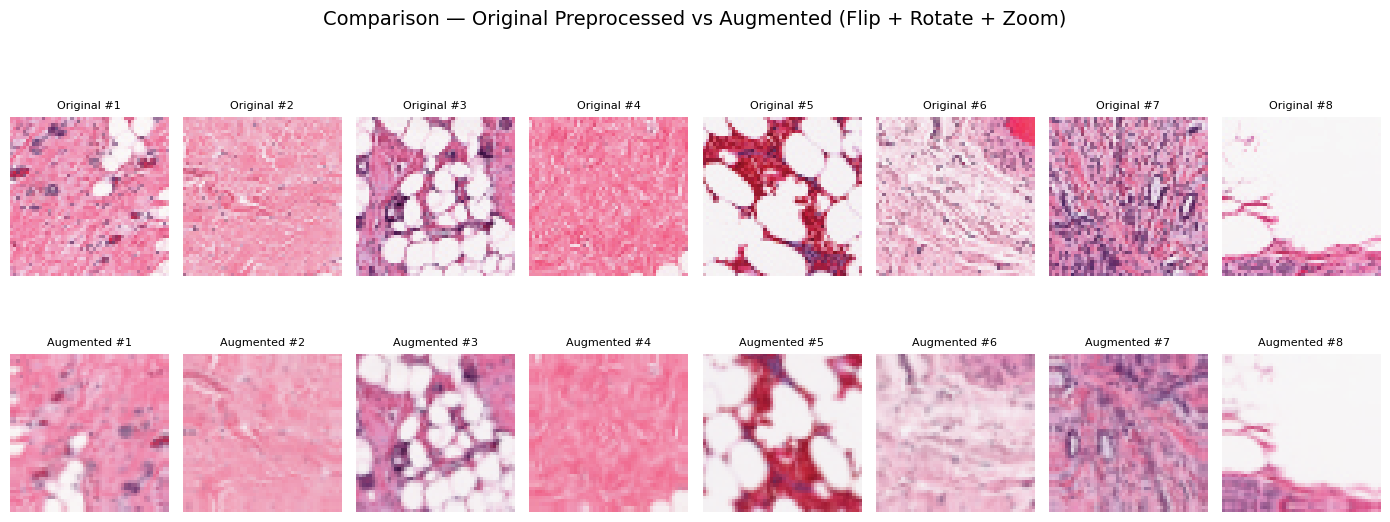

In [44]:
# ✅ Compare Original Preprocessed vs Augmented (Flip + Rotate + Zoom)
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

# ---------- Config ----------
DATA_ROOT = "/content/final_preprocessed"
IMG_SIZE = (50, 50)
BATCH_SIZE = 8   # just for viewing
AUTOTUNE = tf.data.AUTOTUNE

# ---------- Build augmentation layer (same as training) ----------
augment_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.08),   # ±8%
    tf.keras.layers.RandomZoom(0.08),       # ±8%
])

# ---------- Load a small batch from preprocessed train set ----------
view_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_ROOT, "train"),
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
).take(1)

# ---------- Get one batch ----------
for images, labels in view_ds:
    aug_images = augment_layer(images)  # apply aug once
    originals = images.numpy().astype("uint8")
    augmented = aug_images.numpy().astype("uint8")

    n = len(originals)
    plt.figure(figsize=(14, 6))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        plt.imshow(originals[i])
        plt.title(f"Original #{i+1}", fontsize=8)
        plt.axis("off")

        # Augmented
        plt.subplot(2, n, n + i + 1)
        plt.imshow(augmented[i])
        plt.title(f"Augmented #{i+1}", fontsize=8)
        plt.axis("off")

    plt.suptitle("Comparison — Original Preprocessed vs Augmented (Flip + Rotate + Zoom)", fontsize=14)
    plt.tight_layout()
    plt.show()
    break


Found 222018 files belonging to 2 classes.
Found 27751 files belonging to 2 classes.
Found 27755 files belonging to 2 classes.
✅ Augmentation setup: Flip + Rotate + Zoom (on-the-fly, every epoch random)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)         │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 3, 3, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        65,79

 Total params: 1,048,513 (4.00 MB)

 Trainable params: 1,046,529 (3.99 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7590 - loss: 0.5877
Epoch 1: val_loss improved from inf to 3.77222, saving model to /content/idc_cnn5_onfly_aug_best.h5


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 44s 19ms/step - accuracy: 0.7591 - loss: 0.5876 - val_accuracy: 0.3000 - val_loss: 3.7722 - learning_rate: 1.0000e-04
Epoch 2/20
1732/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8287 - loss: 0.4112
Epoch 2: val_loss improved from 3.77222 to 2.22084, saving model to /content/idc_cnn5_onfly_aug_best.h5


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8287 - loss: 0.4112 - val_accuracy: 0.3552 - val_loss: 2.2208 - learning_rate: 1.0000e-04
Epoch 3/20
1732/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8420 - loss: 0.3759
Epoch 3: val_loss improved from 2.22084 to 1.88878, saving model to /content/idc_cnn5_onfly_aug_best.h5


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8420 - loss: 0.3759 - val_accuracy: 0.4768 - val_loss: 1.8888 - learning_rate: 1.0000e-04
Epoch 4/20
1734/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8492 - loss: 0.3584
Epoch 4: val_loss improved from 1.88878 to 1.69216, saving model to /content/idc_cnn5_onfly_aug_best.h5


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8492 - loss: 0.3584 - val_accuracy: 0.4928 - val_loss: 1.6922 - learning_rate: 1.0000e-04
Epoch 5/20
1731/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8523 - loss: 0.3482
Epoch 5: val_loss improved from 1.69216 to 0.78011, saving model to /content/idc_cnn5_onfly_aug_best.h5


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.8523 - loss: 0.3481 - val_accuracy: 0.7877 - val_loss: 0.7801 - learning_rate: 1.0000e-04
Epoch 6/20
1732/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8578 - loss: 0.3372
Epoch 6: val_loss improved from 0.78011 to 0.53009, saving model to /content/idc_cnn5_onfly_aug_best.h5


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8578 - loss: 0.3372 - val_accuracy: 0.8110 - val_loss: 0.5301 - learning_rate: 1.0000e-04
Epoch 7/20
1729/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8599 - loss: 0.3299
Epoch 7: val_loss improved from 0.53009 to 0.47678, saving model to /content/idc_cnn5_onfly_aug_best.h5


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8599 - loss: 0.3299 - val_accuracy: 0.8382 - val_loss: 0.4768 - learning_rate: 1.0000e-04
Epoch 8/20
1728/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8637 - loss: 0.3241
Epoch 8: val_loss did not improve from 0.47678
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8637 - loss: 0.3241 - val_accuracy: 0.7846 - val_loss: 0.6068 - learning_rate: 1.0000e-04
Epoch 9/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8640 - loss: 0.3194
Epoch 9: val_loss did not improve from 0.47678
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8640 - loss: 0.3194 - val_accuracy: 0.8253 - val_loss: 0.4862 - learning_rate: 1.0000e-04
Epoch 10/20
1732/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8664 - loss: 0.3159
Epoch 10: val_loss did not improve from 0.47678

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8664 -

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8681 - loss: 0.3111 - val_accuracy: 0.8499 - val_loss: 0.4105 - learning_rate: 5.0000e-05
Epoch 12/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8683 - loss: 0.3100
Epoch 12: val_loss did not improve from 0.41055
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8683 - loss: 0.3100 - val_accuracy: 0.8416 - val_loss: 0.4136 - learning_rate: 5.0000e-05
Epoch 13/20
1729/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8699 - loss: 0.3076
Epoch 13: val_loss did not improve from 0.41055
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.8699 - loss: 0.3076 - val_accuracy: 0.8173 - val_loss: 0.4794 - learning_rate: 5.0000e-05
Epoch 14/20
1731/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8699 - loss: 0.3075
Epoch 14: val_loss did not improve from 0.41055

Epoch 14: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.86

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8707 - loss: 0.3049 - val_accuracy: 0.8560 - val_loss: 0.3967 - learning_rate: 2.5000e-05
Epoch 16/20
1731/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8707 - loss: 0.3047
Epoch 16: val_loss did not improve from 0.39673
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8707 - loss: 0.3047 - val_accuracy: 0.8496 - val_loss: 0.4133 - learning_rate: 2.5000e-05
Epoch 17/20
1731/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8715 - loss: 0.3047
Epoch 17: val_loss did not improve from 0.39673
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8715 - loss: 0.3047 - val_accuracy: 0.8445 - val_loss: 0.4281 - learning_rate: 2.5000e-05
Epoch 18/20
1733/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8725 - loss: 0.3026
Epoch 18: val_loss improved from 0.39673 to 0.37761, saving model to /content/idc_cnn5_onfly_aug_best.h5


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8725 - loss: 0.3026 - val_accuracy: 0.8606 - val_loss: 0.3776 - learning_rate: 2.5000e-05
Epoch 19/20
1730/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8729 - loss: 0.3022
Epoch 19: val_loss did not improve from 0.37761
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8729 - loss: 0.3022 - val_accuracy: 0.8498 - val_loss: 0.4087 - learning_rate: 2.5000e-05
Epoch 20/20
1734/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8734 - loss: 0.3010
Epoch 20: val_loss did not improve from 0.37761
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8734 - loss: 0.3010 - val_accuracy: 0.8582 - val_loss: 0.3934 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 18.



✅ Model saved: /content/idc_cnn5_onfly_aug.h5


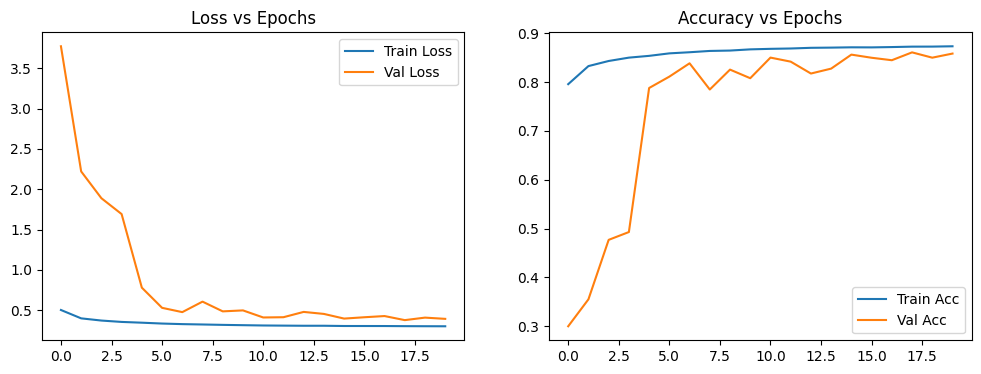


📊 Test Results:
Accuracy : 0.8614
Precision: 0.7202
Recall   : 0.8372
F1-score : 0.7743
ROC-AUC  : 0.9226

Classification Report:
              precision    recall  f1-score   support

           0     0.9310    0.8710    0.9000     19875
           1     0.7202    0.8372    0.7743      7880

    accuracy                         0.8614     27755
   macro avg     0.8256    0.8541    0.8372     27755
weighted avg     0.8712    0.8614    0.8643     27755



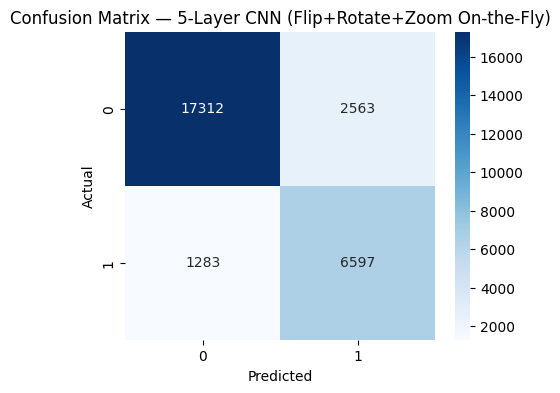


✅ Training Complete — Model trained with On-the-Fly Augmentation


In [49]:
# ✅ IDC Project — 5-Layer CNN + On-the-Fly Augmentation (Flip + Rotate + Zoom)
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns
import os

# ---------- CONFIG ----------
DATA_ROOT = "/content/final_preprocessed"
IMG_SIZE = (50, 50)
BATCH_SIZE = 128
EPOCHS =20
AUTOTUNE = tf.data.AUTOTUNE
MODEL_PATH = "/content/idc_cnn5_onfly_aug.h5"
CHECKPOINT_PATH = "/content/idc_cnn5_onfly_aug_best.h5"
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)
import random
random.seed(SEED)

# ---------- AUGMENTATION (on-the-fly) ----------
augment_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.08),   # ±8% (~±30°)
    tf.keras.layers.RandomZoom(0.08),       # ±8% zoom
])

def augment_fn(images, labels):
    return augment_layer(images), labels

# ---------- DATASET PIPELINE ----------
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_ROOT, "train"),
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_ROOT, "val"),
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_ROOT, "test"),
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

# Apply augmentation only to train_ds (on the fly)
train_ds = train_ds.map(augment_fn, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

print("✅ Augmentation setup: Flip + Rotate + Zoom (on-the-fly, every epoch random)")

# ---------- MODEL: 5-LAYER CNN with Strong Dropout ----------
def build_cnn5_strongdrop(input_shape=(*IMG_SIZE, 3)):
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),

        # Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.4),

        # Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.45),

        # Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.5),

        # Block 4
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.55),

        # Block 5
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.6),

        # Dense Head
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = build_cnn5_strongdrop()
model.summary()

# ---------- COMPILE ----------
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# ---------- CALLBACKS ----------
cb_list = [
    callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor="val_loss", save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

# ---------- TRAIN ----------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cb_list,
    verbose=1
)

# Save model
model.save(MODEL_PATH)
print(f"\n✅ Model saved: {MODEL_PATH}")

# ---------- PLOTS ----------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss vs Epochs')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy vs Epochs')
plt.show()

# ---------- EVALUATION ----------
y_true, y_pred, y_prob = [], [], []
for imgs, labels in test_ds:
    probs = model.predict(imgs, verbose=0).ravel()
    preds = (probs >= 0.5).astype(int)
    y_true.extend(labels.numpy().astype(int))
    y_pred.extend(preds)
    y_prob.extend(probs)

y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc = roc_auc_score(y_true, y_prob)

print(f"\n📊 Test Results:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — 5-Layer CNN (Flip+Rotate+Zoom On-the-Fly)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n✅ Training Complete — Model trained with On-the-Fly Augmentation")


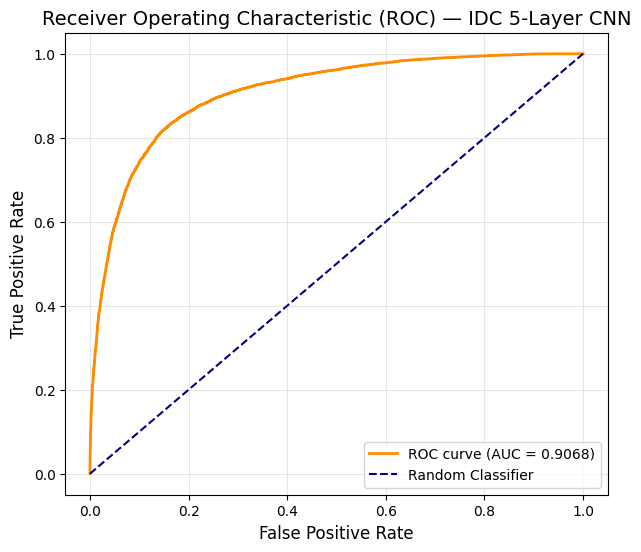

✅ ROC-AUC Score: 0.9068


In [52]:
# ✅ ROC Curve and AUC Evaluation for IDC CNN Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

# --- Collect predictions and true labels ---
y_true = []
y_prob = []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0).ravel()  # get sigmoid probabilities
    y_true.extend(labels.numpy().astype(int))
    y_prob.extend(probs)

y_true = np.array(y_true)
y_prob = np.array(y_prob)

# --- Compute ROC metrics ---
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

# --- Plot ROC Curve ---
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) — IDC 5-Layer CNN', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

print(f"✅ ROC-AUC Score: {roc_auc:.4f}")
